# **DevOps a szakképzésben**
##### Englert Ervin
***

![devops](https://github.com/englert/itmp/blob/master/devops.png?raw=true)
***

## **A DevOps módszertan jellemzői**
* gyors
* nagy teljesítmény
* dokumentált
* megismételhető
***

## **A DevOps eszözei**

* verziókezelés
        Git
* virtualizálás, konténer technikák
        KVM, LxC, LxD, Proxmox, Docker 
* automatizálás
        Ansible
* tesztelés
* monitorozás

***


## Mátó Péter: Hogyan legyél DevOps?

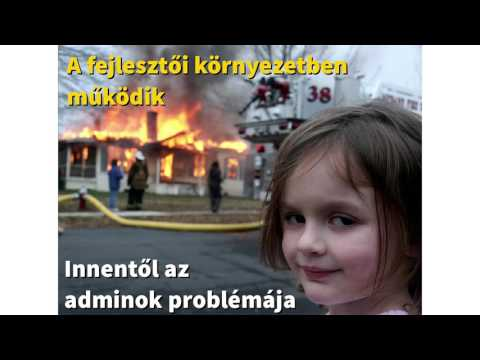

In [10]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('koip76r6Ba0',width=800,height=400)

***

### Feladat: Futtasunk egy docker alapú webszervert az Amazon felhőszolgáltatásán

##### Github:
* **Hozzunk létre a githubon egy repositoryt nginx néven.**
* **Hozzunk létre a githubon egy fájlt Dockerfile néven.**
* **Kezdjük szerkeszteni a Dockerfile-t.**
* **Ellenőrizzűk a githubon a comittokat.**

##### A saját gépen:
* **Github repository klónozása a saját gépre:**

In [11]:

!git clone git@github.com:englert/nginx.git
#git clone https://github.com/englert/nginx.git

Cloning into 'nginx'...
remote: Counting objects: 29, done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 15.88 KiB | 0 bytes/s, done.
Resolving deltas: 100% (9/9), done.
Checking connectivity... done.


* **Wget segítségével "raboljunk le" egy weboldalt:**

In [12]:
%%bash
cd nginx
wget https://bmszc-ujpesti.e-kreta.hu -r -q

In [14]:
!ls nginx

bmszc-ujpesti.e-kreta.hu  Dockerfile  README.md


* **Dockerfile szerkesztése:**

In [15]:
%%file nginx/Dockerfile
FROM nginx:latest

 COPY bmszc-ujpesti.e-kreta.hu /usr/share/nginx/html
 
 EXPOSE 80 443     

 CMD ["nginx", "-g", "daemon off;"]



Overwriting nginx/Dockerfile


* **Készítsük el a docker image-t.**

In [17]:
%%bash
cd nginx
docker image build --tag englert/nginx:1.0 .

Sending build context to Docker daemon  10.89MB
Step 1/4 : FROM nginx:latest
 ---> 7f70b30f2cc6
Step 2/4 : COPY bmszc-ujpesti.e-kreta.hu /usr/share/nginx/html
 ---> 476de10e6126
Step 3/4 : EXPOSE 80 443
 ---> Running in 372a4a63c32d
Removing intermediate container 372a4a63c32d
 ---> a437186927eb
Step 4/4 : CMD ["nginx", "-g", "daemon off;"]
 ---> Running in 0b79cd824ef2
Removing intermediate container 0b79cd824ef2
 ---> 5e61487d20c2
Successfully built 5e61487d20c2
Successfully tagged englert/nginx:1.0


* **Indítsuk el a docker konténert a saját gépünkön.**

In [18]:
!docker container run --detach -p 80:80 englert/nginx

e1a89dea6df58097e31e34e5475a194be03b59e84b147012214232a8f1d88601


* **Indítsunk el egy böngészőt a 127.0.0.1 címre.**

In [19]:
!firefox 127.0.0.1

* **A lokális gitben kommittoljuk el a változásokat.**

In [20]:
%%bash
cd nginx
git add .
git commit -m"nginx 1.0"

[master 97cf906] nginx 1.0
 69 files changed, 2858 insertions(+), 3 deletions(-)
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Adminisztracio/Login/ChangeLanguage/1038
 create mode 100644 bmszc-ujpesti.e-kreta.hu/App_Themes/Common_Images/flag_hu.png
 create mode 100644 bmszc-ujpesti.e-kreta.hu/App_Themes/Skin_Kreta_Gfx/content/images/kreta_feher_login.png
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/content/images/Information_icon.png
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/content/images/kreta_feher_innerpages.png
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/content/images/kreta_icon.png
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/content/images/ugyfelszolgalat_icon.png
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/css?v=u1qutpmV-e_XBq8wmPPXbxlfbuQHWeOCluYvOO8bLIk1
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/font-awesome.min.css
 create mode 100644 bmszc-ujpesti.e-kreta.hu/Content/kendo/2016.2.607/mobile/images/kendoui.svg
 create m

* **Toljuk fel a githubra a vátozásokat.**

In [23]:
%%bash
cd nginx
git push

Everything up-to-date


* **A Dockerhubon állítsuk be az automa buildet a github repositoryra**

In [43]:
%%file hosts

#localhost ansible_connection=local
docker1 ansible_host=www.unibox.hu ansible_ssh_private_key_file=/home/sis/.ssh/aws.pem

[docker]
docker1
[docker:vars]
ansible_port=22 
ansible_connection=ssh 
ansible_python_interpreter=/usr/bin/python3
ansible_user=ubuntu
ansible_ssh_private_key_file=/home/sis/.ssh/aws.pem


Overwriting hosts


In [90]:
!ansible -i ./hosts -m ping docker1

docker1 | SUCCESS => {
    "changed": false,
    "ping": "pong"
}


In [91]:
%%file docker-nginx-start.yml
---
- hosts: docker
  remote_user: ubuntu
  tasks:
  - name: "Configure app server(s)"
    docker_container:
      name: nginx in docker
      image: englert/nginx
      state: present
      restart: yes
      ports:
      - "80:80"

Overwriting docker-nginx-start.yml


In [92]:
!ansible-playbook -i ./hosts ./docker-nginx-start.yml -t docker1


PLAY [docker] ******************************************************************

TASK [Gathering Facts] *********************************************************
ok: [docker1]

PLAY RECAP *********************************************************************
docker1                    : ok=1    changed=0    unreachable=0    failed=0   



In [76]:
!firefox www.unibox.hu


In [69]:
%%file docker-nginx-stop.yml
---
- hosts: docker
  remote_user: ubuntu
  tasks:
  - name: "Configure app server(s)"
    docker:
      name: nginx in docker
      image: englert/nginx
      state: stopped
      ports:
      - "80:80"

Overwriting docker-nginx-stop.yml


In [70]:
!ansible-playbook -i ./hosts ./docker-nginx-stop.yml -t docker1

[DEPRECATION WARNING]: docker is kept for backwards compatibility but usage is 
discouraged. The module documentation details page may explain more about this 
rationale.. This feature will be removed in a future release. Deprecation 
warnings can be disabled by setting deprecation_warnings=False in ansible.cfg.

PLAY [docker] ******************************************************************

TASK [Gathering Facts] *********************************************************
ok: [docker1]

PLAY RECAP *********************************************************************
docker1                    : ok=1    changed=0    unreachable=0    failed=0   



In [71]:
!firefox www.unibox.hu